# Predspracovanie údajov
### Projekt z predmetu Inteligentná analýza údajov
#### Martin L. Zachar, Štefan Šebeň

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn
import matplotlib.pyplot as plt
%matplotlib inline


pd.set_option('display.max_columns', 50)

In [2]:
train_data = pd.read_csv('data/explorovane.csv', index_col='id')
train_data.head()

,age,on thyroxine,query on thyroxine,pregnant,thyroid surgery,I131 treatment,lithium,goitre,tumor,hypopituitary,TSH,T3 measured,T3,TT4,T4U,FTI measured,TBG measured,TBG,referral source,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,capital-gain,capital-loss,hours-per-week,native-country,date_of_birth,TSH measured,sex,query hyperthyroid,TT4 measured,on antithyroid medication,FTI,sick,T4U measured,psych,query hypothyroid,test,testID
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,82.0,f,f,f,f,f,f,f,f,f,2.2,t,1.0,68.0,0.77,t,f,NaN,SVI,Local-gov,141649,Assoc-voc,11,Married-civ-spouse,Protective-serv,Husband,White,0,0,40,United-States,1935-05-20 00:00:00,t,M,f,t,f,88.0,f,t,f,f,negative,991
1,50.0,f,f,f,t,f,f,f,f,f,76.0,t,0.5,22.0,1.12,t,f,NaN,other,Local-gov,177599,Bachelors,13,Divorced,Prof-specialty,Unmarried,White,0,0,35,United-States,67-08-03,t,F,f,t,f,19.0,f,t,f,f,negative,1685
2,41.0,f,f,f,f,f,f,f,f,f,NaN,t,2.0,99.0,0.96,t,f,NaN,other,Self-emp-not-inc,102631,Some-college,10,Widowed,Farming-fishing,Unmarried,White,0,0,50,United-States,1976-05-02,f,F,f,t,f,104.0,f,t,f,f,negative,3504
3,73.0,f,f,f,f,f,f,f,f,f,0.7,t,2.0,116.0,0.99,t,f,NaN,other,private,272338,HS-grad,9,Married-civ-spouse,Adm-clerical,Wife,White,0,0,25,United-States,44-10-08,t,F,f,t,f,117.0,f,t,f,f,negative,1942
4,64.0,f,f,f,f,f,f,f,f,f,2.0,t,1.8,80.0,0.91,t,f,NaN,SVHC,Self-emp-inc,368825,Some-college,10,Married-civ-spouse,Sales,Husband,White,0,0,60,United-States,1953-05-01,t,M,f,t,f,88.0,f,t,f,f,negative,2009


In [3]:
import re

dates = train_data['date_of_birth'].dropna()
dates = list(map(lambda s: re.split(' |-|/|:', s) ,dates))

print("Neidentifikovatelne: ", len(list(filter(lambda d: int(d[0]) <= 31 and int(d[2]) <= 31, dates))))
print("Rok bez uvodnych cisel: ", len(list(filter(lambda d: int(d[0]) < 1900 and int(d[0]) > 31 and int(d[2]) <= 31, dates))))
print("Vymeneny rok a den: ", len(list(filter(lambda d: int(d[0]) <= 31 and int(d[2]) > 1900, dates))))
print("Zly mesiac: ", len(list(filter(lambda d: int(d[1]) > 12, dates))))
print("S casom dna: ", len(list(filter(lambda d: len(d) > 3, dates))))        

Neidentifikovatelne:  5
Rok bez uvodnych cisel:  189
Vymeneny rok a den:  180
Zly mesiac:  0
S casom dna:  382


Pridáme nové stĺpce pre rok a mesiac. Istá sezónnosť v rámci mesiacov roka nemusí byť nutne vylúčená (vplyvy počasia a podnebia apod.), podobne aj

In [4]:
train_data['birth_year'] = np.nan
train_data['birth_month'] = np.nan

In [5]:
for i in range(train_data.shape[0]-1):
    if (pd.isna(train_data.loc[i]['date_of_birth'])):
        continue
    date = list(map(int, re.split(' |-|/|:', train_data.iloc[i]['date_of_birth'])))
    if date[0] <= 31 and date[2] <= 31:
        continue
    elif date[0] <= 31 and date[2] > 31:
        b = date[2]
        date[2] = date[0]
        date[0] = b
    if date[0] < 1900:
        if date[0] < 18:
            date[0] = date[0] + 2000
        else:
            date[0] = date[0] + 1900
    if len(date) > 3:
        date = date[:3]
    train_data.loc[i, 'birth_year'] = date[0]
    train_data.loc[i, 'birth_month'] = date[1]
    
train_data.head()

,age,on thyroxine,query on thyroxine,pregnant,thyroid surgery,I131 treatment,lithium,goitre,tumor,hypopituitary,TSH,T3 measured,T3,TT4,T4U,FTI measured,TBG measured,TBG,referral source,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,capital-gain,capital-loss,hours-per-week,native-country,date_of_birth,TSH measured,sex,query hyperthyroid,TT4 measured,on antithyroid medication,FTI,sick,T4U measured,psych,query hypothyroid,test,testID,birth_year,birth_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,82.0,f,f,f,f,f,f,f,f,f,2.2,t,1.0,68.0,0.77,t,f,NaN,SVI,Local-gov,141649,Assoc-voc,11,Married-civ-spouse,Protective-serv,Husband,White,0,0,40,United-States,1935-05-20 00:00:00,t,M,f,t,f,88.0,f,t,f,f,negative,991,1935.0,5.0
1,50.0,f,f,f,t,f,f,f,f,f,76.0,t,0.5,22.0,1.12,t,f,NaN,other,Local-gov,177599,Bachelors,13,Divorced,Prof-specialty,Unmarried,White,0,0,35,United-States,67-08-03,t,F,f,t,f,19.0,f,t,f,f,negative,1685,1967.0,8.0
2,41.0,f,f,f,f,f,f,f,f,f,NaN,t,2.0,99.0,0.96,t,f,NaN,other,Self-emp-not-inc,102631,Some-college,10,Widowed,Farming-fishing,Unmarried,White,0,0,50,United-States,1976-05-02,f,F,f,t,f,104.0,f,t,f,f,negative,3504,1976.0,5.0
3,73.0,f,f,f,f,f,f,f,f,f,0.7,t,2.0,116.0,0.99,t,f,NaN,other,private,272338,HS-grad,9,Married-civ-spouse,Adm-clerical,Wife,White,0,0,25,United-States,44-10-08,t,F,f,t,f,117.0,f,t,f,f,negative,1942,1944.0,10.0
4,64.0,f,f,f,f,f,f,f,f,f,2.0,t,1.8,80.0,0.91,t,f,NaN,SVHC,Self-emp-inc,368825,Some-college,10,Married-civ-spouse,Sales,Husband,White,0,0,60,United-States,1953-05-01,t,M,f,t,f,88.0,f,t,f,f,negative,2009,1953.0,5.0


In [6]:
from scipy.stats import boxcox
from functools import reduce

#algoritmus prevzany z http://colingorrie.github.io/outlier-detection.html
def findOutliers(data, verbose=False):
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    lowerFrontier = q1 - (iqr * 1.5)
    upperFrontier = q3 + (iqr * 1.5)
    if verbose:
        print ("Dolna hranica: ", lowerFrontier)
        print ("Horna hranica: ", upperFrontier)
    return np.where((data > upperFrontier) | (data < lowerFrontier))[0]

def replaceOutliers5_95PercentileS(data):
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    lowerFrontier = q1 - (iqr * 1.5)
    upperFrontier = q3 + (iqr * 1.5)
    
    p5, p95 = np.percentile(data, [5, 95])
    print(p5, p95)
    for i in range(data.shape[0]):
        if (data[i] < lowerFrontier):
            data[i] = p5
        elif (data[i] > upperFrontier):
            data[i] = p95
            
    return data

def replaceOutliers5_95Percentile(data):
    q1, q3 = np.percentile(data.dropna(), [25, 75])
    iqr = q3 - q1
    lowerFrontier = q1 - (iqr * 1.5)
    upperFrontier = q3 + (iqr * 1.5)
    
    p5, p95 = np.percentile(data.dropna(), [5, 95])
    print(p5, p95)
    for i in range(data.shape[0]):
        if (data[i] < lowerFrontier):
            data[i] = p5
        elif (data[i] > upperFrontier):
            data[i] = p95
            
    return data

Text(0.5,1,'TSH (log transform)')

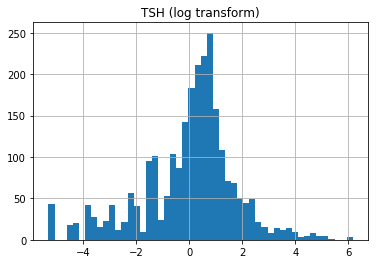

In [7]:
transformed = np.log(train_data['TSH'])
pom = pd.Series(transformed).hist(bins=50)
pom.set_title("TSH (log transform)")

Pocet outlierov (orig):  277
Dolna hranica:  -3.4759944471803537
Horna hranica:  3.674167306841612
Pocet outlierov:  156


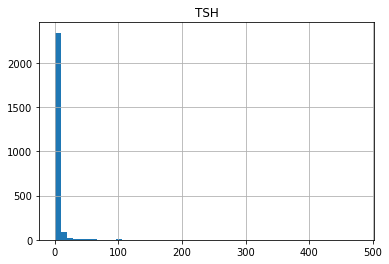

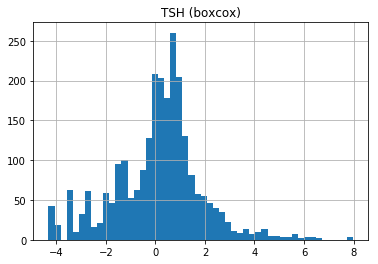

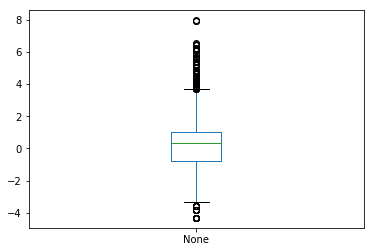

In [8]:
trans, att = boxcox(train_data['TSH'].dropna())

pd.Series(train_data['TSH'].dropna()).hist(bins=50).set_title("TSH")
plt.figure()
pd.Series(trans).hist(bins=50).set_title("TSH (boxcox)")
plt.figure()
pd.Series(trans).plot(kind='box')
plt.figure()

print('Pocet outlierov (orig): ', len(findOutliers(train_data['TSH'].dropna())));
print('Pocet outlierov: ', len(findOutliers(trans, True)));

-3.195822633347939 2.7482037242797794


Text(0.5,1,'TSH')

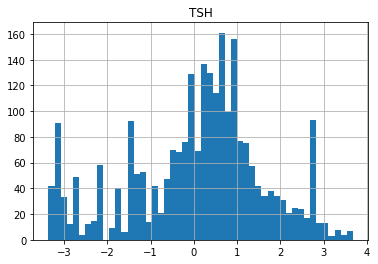

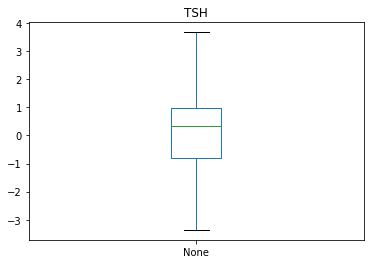

In [9]:
trans, att = boxcox(train_data['TSH'].dropna())

trans = replaceOutliers5_95PercentileS(trans)

pd.Series(trans).hist(bins=50).set_title("TSH")
plt.figure()
pd.Series(trans).plot(kind='box').set_title("TSH")

#train_data['TSH'] = trans

Pocet outlierov:  146


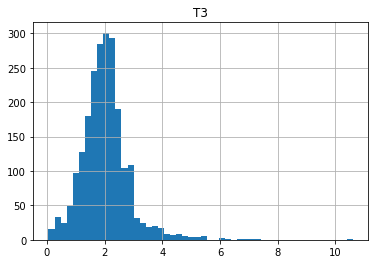

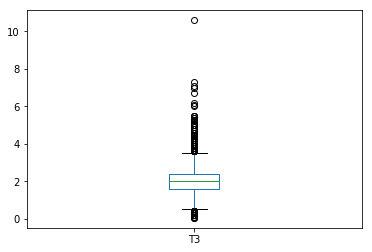

In [10]:
pd.Series(train_data['T3']).hist(bins=50).set_title("T3")
plt.figure()
pd.Series(train_data['T3']).plot(kind='box')
plt.figure()

print('Pocet outlierov: ', len(findOutliers(train_data['T3'].dropna())));

0.8 3.4


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Text(0.5,1,'T3')

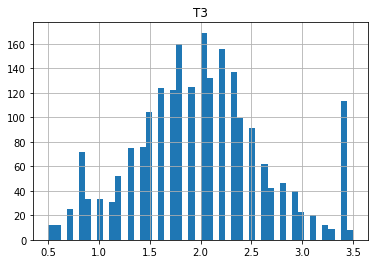

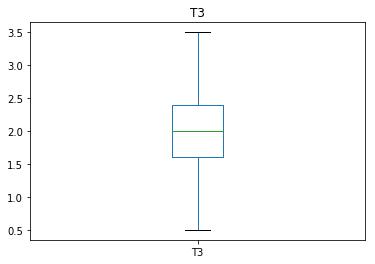

In [11]:
trans = replaceOutliers5_95Percentile(train_data['T3'])

pd.Series(trans).hist(bins=50).set_title("T3")
plt.figure()
pd.Series(trans).plot(kind='box').set_title("T3")

Pocet outlierov:  121
Pocet outlierov:  109


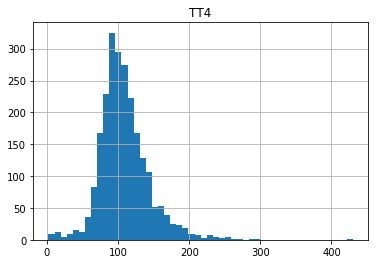

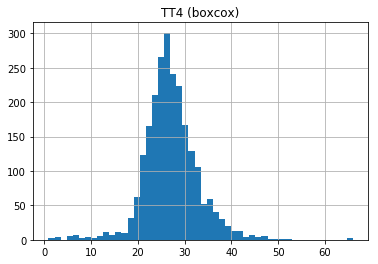

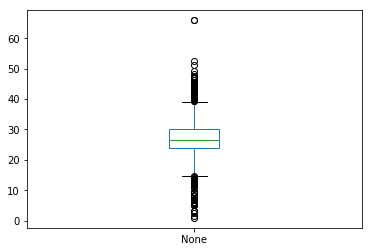

In [12]:
trans, att = boxcox(train_data['TT4'].dropna())

pd.Series(train_data['TT4'].dropna()).hist(bins=50).set_title("TT4")
plt.figure()
pd.Series(trans).hist(bins=50).set_title("TT4 (boxcox)")
plt.figure()
pd.Series(trans).plot(kind='box')
plt.figure()

print('Pocet outlierov: ', len(findOutliers(train_data['TT4'].dropna())));
print('Pocet outlierov: ', len(findOutliers(trans)));

63.55000000000001 171.0


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Text(0.5,1,'TT4')

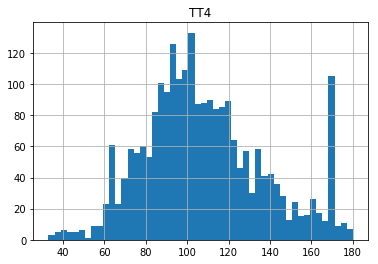

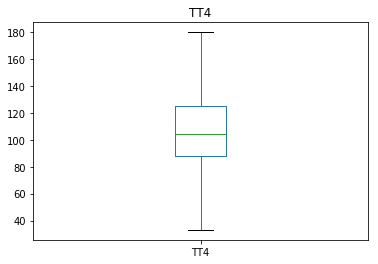

In [13]:
trans = replaceOutliers5_95Percentile(train_data['TT4'])

pd.Series(trans).hist(bins=50).set_title("TT4")
plt.figure()
pd.Series(trans).plot(kind='box').set_title("TT4")

Pocet outlierov:  124
Pocet outlierov:  115


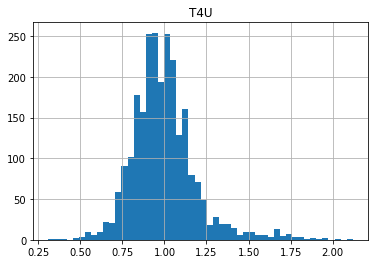

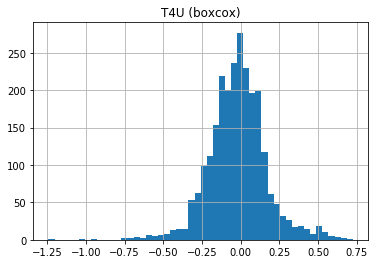

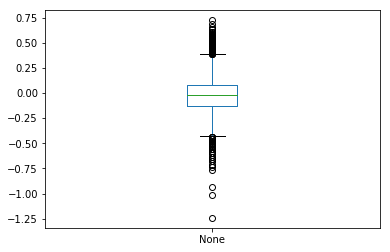

In [14]:
trans, att = boxcox(train_data['T4U'].dropna())

pd.Series(train_data['T4U'].dropna()).hist(bins=50).set_title("T4U")
plt.figure()
pd.Series(trans).hist(bins=50).set_title("T4U (boxcox)")
plt.figure()
pd.Series(trans).plot(kind='box')
plt.figure()

print('Pocet outlierov: ', len(findOutliers(train_data['T4U'].dropna())));
print('Pocet outlierov: ', len(findOutliers(trans)));

0.74 1.34


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Text(0.5,1,'T4U')

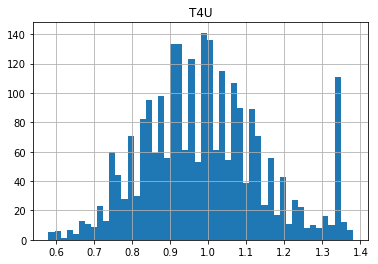

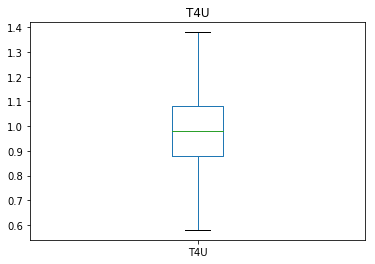

In [15]:
trans = replaceOutliers5_95Percentile(train_data['T4U'])

pd.Series(trans).hist(bins=50).set_title("T4U")
plt.figure()
pd.Series(trans).plot(kind='box').set_title("T4U")

Pocet outlierov:  152
Pocet outlierov:  137


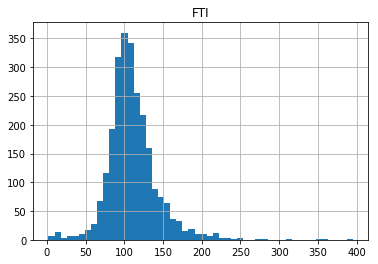

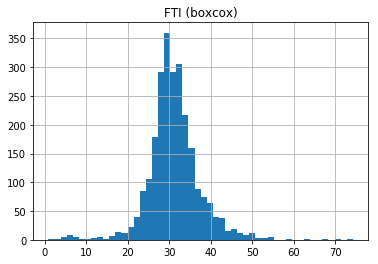

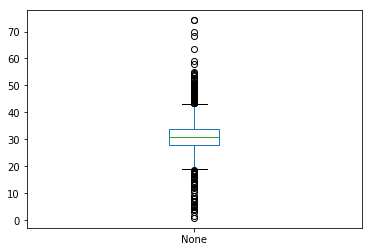

In [ ]:
trans, att = boxcox(train_data['FTI'].dropna())

pd.Series(train_data['FTI'].dropna()).hist(bins=50).set_title("FTI")
plt.figure()
pd.Series(trans).hist(bins=50).set_title("FTI (boxcox)")
plt.figure()
pd.Series(trans).plot(kind='box')
plt.figure()

print('Pocet outlierov: ', len(findOutliers(train_data['FTI'].dropna())));
print('Pocet outlierov: ', len(findOutliers(trans)));

In [ ]:
trans = replaceOutliers5_95Percentile(train_data['FTI'])

pd.Series(trans).hist(bins=50).set_title("FTI")
plt.figure()
pd.Series(trans).plot(kind='box').set_title("FTI")

70.0 166.0


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [ ]:
trans, att = boxcox(train_data['fnlwgt'].dropna())

pd.Series(train_data['fnlwgt'].dropna()).hist(bins=50).set_title("fnlwgt")
plt.figure()
pd.Series(trans).hist(bins=50).set_title("fnlwgt (boxcox)")
plt.figure()
pd.Series(trans).plot(kind='box')
plt.figure()

print('Pocet outlierov: ', len(findOutliers(train_data['fnlwgt'].dropna())));
print('Pocet outlierov: ', len(findOutliers(trans)));

#train_data['fnlwgt'] = trans

In [ ]:
trans, att = boxcox(train_data['fnlwgt'].dropna())

trans = replaceOutliers5_95PercentileS(trans)

pd.Series(trans).hist(bins=50).set_title("fnlwgt")
plt.figure()
pd.Series(trans).plot(kind='box').set_title("fnlwgt")

In [ ]:
trans, att = boxcox(train_data['hours-per-week'].dropna())

pd.Series(train_data['hours-per-week'].dropna()).hist(bins=50).set_title("hours-per-week")
plt.figure()
pd.Series(trans).hist(bins=50).set_title("hours-per-week (boxcox)")
plt.figure()
pd.Series(trans).plot(kind='box')
plt.figure()
print('Pocet outlierov: ', len(findOutliers(train_data['hours-per-week'].dropna())));
print('Pocet outlierov: ', len(findOutliers(trans)));

In [ ]:
trans = replaceOutliers5_95Percentile(train_data['hours-per-week'])

pd.Series(trans).hist(bins=50).set_title("hours-per-week")
plt.figure()
pd.Series(trans).plot(kind='box').set_title("hours-per-week")

In [ ]:
p5, p95 = np.percentile(train_data['age'], [5, 95])

train_data[train_data['age']==455] = p95

In [ ]:
for i in range (len(train_data['education-num'])):
    if train_data.loc[i, 'education-num'] < 0:
        train_data.loc[i, 'education-num'] *= -1
    if train_data.loc[i, 'education-num'] >= 100:
        train_data.loc[i, 'education-num'] = train_data.loc[i, 'education-num']/100

Pouzitie box-cox na capital-weight a capital-loss nemobolo mozne, pri zlogaritmovani nedoslo k znatelnej zmene.

sklearn.Imputer - nahradzanie hodnot
fancyimpute

In [ ]:
for column in train_data.columns:
    if np.issubdtype(train_data[column].dtype, np.number):
        if train_data[column].std() / train_data[column].mean() <= 1:
            mean = train_data[column].mean()
            for i in range(len(train_data[column])):
                if (np.isnan(train_data.loc[i, column])):
                    train_data.loc[i, column] = mean
        else:
            median = train_data[column].median()
            for i in range(len(train_data[column])):
                if (np.isnan(train_data.loc[i, column])):
                    train_data.loc[i, column] = median

In [ ]:
for column in train_data.columns:
    if np.issubdtype(train_data[column].dtype, np.number):
        train_data[column].hist(bins=50).set_title(column)
        plt.figure()

In [ ]:
train_data['education-num'].hist(bins=50).set_title('education-num')